In [13]:
import pandas as pd
import numpy as np
import multiprocessing
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- Classifiers ---
from joblib import parallel_config
from joblib import parallel_backend
from sklearn.naive_bayes import MultinomialNB as NBMult
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.tree import DecisionTreeClassifier as DTClassifier
from sklearn.ensemble import RandomForestClassifier as RFClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
from scipy.stats import randint

In [2]:
# Constants
CPU_COUNT = os.cpu_count() or multiprocessing.cpu_count()
USE_HASHING = True

In [3]:
def prepare_features(df, text_col="text_combined", label_col="label", use_hashing=USE_HASHING, max_features=3000):
    """Prepare text features using TF-IDF vectorization."""
    texts = df[text_col].astype(str).tolist()
    labels = df[label_col].values

    if use_hashing:
        print("Using HashingVectorizer + TfidfTransformer (faster/lower-memory)")
        hasher = HashingVectorizer(n_features=max_features, alternate_sign=False, norm=None, ngram_range=(1, 2))
        X_h = hasher.transform(texts)
        tfidf_trans = TfidfTransformer()
        X = tfidf_trans.fit_transform(X_h)
        vectorizer_obj = (hasher, tfidf_trans)
    else:
        print("Using standard TfidfVectorizer")
        vectorizer = TfidfVectorizer(max_features=max_features, stop_words="english", ngram_range=(1, 2))
        X = vectorizer.fit_transform(texts)
        vectorizer_obj = vectorizer

    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)
    return X_train, X_test, y_train, y_test, vectorizer_obj

In [4]:
def get_models():
    """Return a dictionary of ML models used for text classification experiments."""
    model_set = {
        "naive_bayes": NBMult(),
        "logistic_regression": LogReg(max_iter=2000),
        "decision_tree": DTClassifier(),
        "random_forest": RFClassifier(n_estimators=150, random_state=42)
    }
    return model_set

In [5]:
def train_predict_evaluate(models, X_train, X_test, y_train, y_test):
    """
    Train, predict, and evaluate multiple models in a single pipeline.

    Args:
        models (dict): Model name -> model object
        X_train, X_test: Feature matrices
        y_train, y_test: Labels

    Returns:
        results (dict): Accuracy & F1 for each model
        predictions (dict): Predicted labels for each model
        probabilities (dict): Predicted probabilities for ROC/PR
    """
    results = {}
    predictions = {}
    probabilities = {}

    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Store predictions & probabilities
        predictions[name] = preds
        probabilities[name] = probs

        # Evaluate
        acc = accuracy_score(y_test, preds) * 100
        f1 = f1_score(y_test, preds) * 100

        # Print results
        print(f"\n{name} Results:")
        print(f"Accuracy: {acc:.2f} %")
        print(f"F1 Score: {f1:.2f} %")
        print(classification_report(y_test, preds))

        # Store metrics
        results[name] = {"Accuracy": acc, "F1 Score": f1}

    return results, predictions, probabilities

In [6]:
def tune_random_forest(X_train, y_train, n_jobs=None):
    """
    Tune Random Forest hyperparameters using RandomizedSearchCV.

    Args:
        X_train: Training features
        y_train: Training labels
        n_jobs: Number of parallel jobs (defaults to CPU_COUNT)

    Returns:
        Best estimator from the search
    """
    if n_jobs is None:
        n_jobs = CPU_COUNT

    param_dist = {
        "n_estimators": randint(100, 350),
        "max_depth": randint(5, 40),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", None]
    }

    rf = RFClassifier(random_state=42)

    tuner = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=10,
        cv=2,
        scoring="accuracy",
        n_jobs=n_jobs,
        verbose=1,
        random_state=42
    )

    tuner.fit(X_train, y_train)

    print("\n🔍 Best Parameters:", tuner.best_params_)
    print("🏆 Best Accuracy:", tuner.best_score_)

    return tuner.best_estimator_


In [7]:
def summarize_results(results_dict, show_heatmap=True):
    """
    Convert results dictionary to DataFrame, sort by Accuracy,
    and optionally show a heatmap for quick comparison.

    Args:
        results_dict (dict): Model -> {'Accuracy': ..., 'F1 Score': ...}
        show_heatmap (bool): If True, display a seaborn heatmap

    Returns:
        pd.DataFrame: Sorted summary table
    """
    # Convert to DataFrame
    results_df = pd.DataFrame(results_dict).T

    # Format as percentages
    results_df = results_df.apply(lambda x: round(x, 2))

    # Sort by Accuracy descending
    results_df = results_df.sort_values(by="Accuracy", ascending=False)

    # Print summary table
    print("\nSummary Table (sorted by Accuracy):")
    print(results_df)

    # Optional heatmap
    if show_heatmap:
        plt.figure(figsize=(6, len(results_df) * 0.6))
        sns.heatmap(results_df, annot=True, fmt=".2f", cmap="YlGnBu")
        plt.title("Model Performance Comparison")
        plt.show()

    return results_df


In [8]:
def plot_confusion_matrices(y_true, prediction_dict, cmap="Blues"):
    """
    Draws confusion matrices for multiple classification models.

    Parameters:
        y_true (array-like): Actual labels
        prediction_dict (dict): {model_name: predictions_array}
        cmap (str): Color map for heatmap
    """
    for model_name, preds in prediction_dict.items():
        cm = confusion_matrix(y_true, preds)

        plt.figure(figsize=(5.5, 4.5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap=cmap,
            linewidths=0.5,
            cbar=False
        )

        plt.title(f"Confusion Matrix – {model_name}", fontsize=12)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()


Detected CPUs: 8
Environment threads set: 8
                                           text_combined  label
0      hpl nom may 25 2001 see attached file hplno 52...      0
1      nom actual vols 24 th forwarded sabrae zajac h...      0
2      enron actuals march 30 april 1 201 estimated a...      0
3      hpl nom may 30 2001 see attached file hplno 53...      0
4      hpl nom june 1 2001 see attached file hplno 60...      0
...                                                  ...    ...
82481  info advantageapartmentscom infoadvantageapart...      1
82482  monkeyorg helpdeskmonkeyorg monkeyorg hi josep...      1
82483  help center infohelpcentercoza_infohelpcenterc...      1
82484  metamask infosofamekarcom verify metamask wall...      1
82485  fastway infofastwaycoza_infofastwaycoza_infofa...      1

[82486 rows x 2 columns]
Using HashingVectorizer + TfidfTransformer (faster/lower-memory)

naive_bayes Results:
Accuracy: 87.71 %
F1 Score: 87.18 %
              precision    recall  f1-s

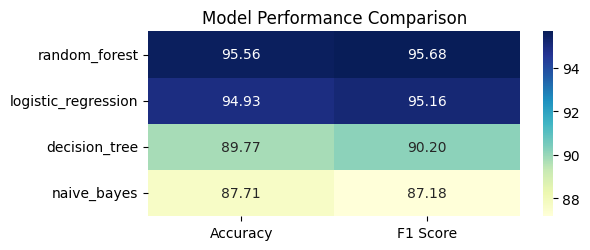


Confusion Matrices


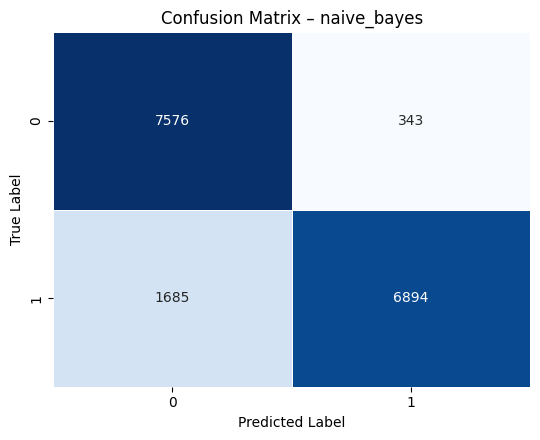

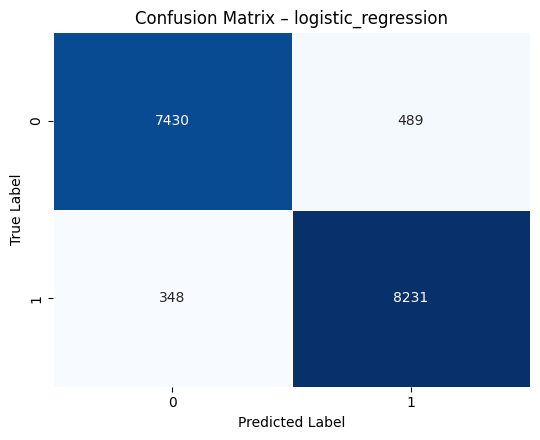

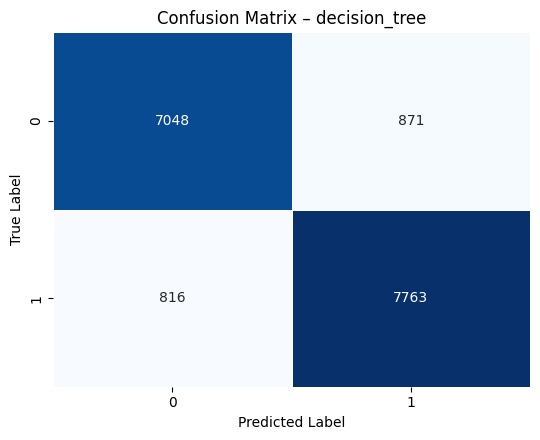

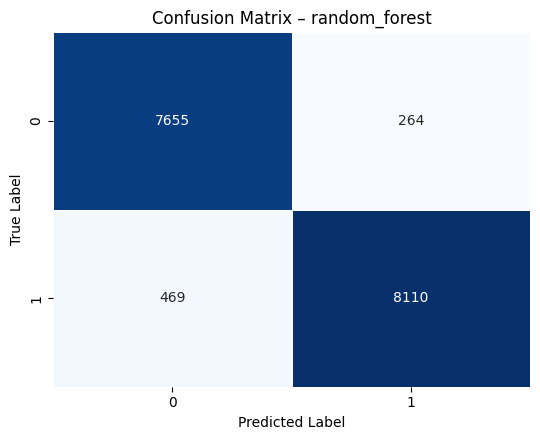

In [9]:
if __name__ == "__main__":
    # Set environment variables
    os.environ['OMP_NUM_THREADS'] = str(CPU_COUNT)
    os.environ['OPENBLAS_NUM_THREADS'] = str(CPU_COUNT)
    os.environ['MKL_NUM_THREADS'] = str(CPU_COUNT)

    # Load data
    print(f"Detected CPUs: {CPU_COUNT}")
    print("Environment threads set:", os.environ['OMP_NUM_THREADS'])

    data = pd.read_csv("phishing_email.csv")
    print(data)

    # Prepare features
    X_train, X_test, y_train, y_test, vectorizer_obj = prepare_features(data)

    # Get models and train
    models = get_models()
    results, predictions, probabilities = train_predict_evaluate(models, X_train, X_test, y_train, y_test)

    # Tune Random Forest
    print("\n" + "=" * 50)
    print("Starting Random Forest Hyperparameter Tuning...")
    print("=" * 50)
    best_rf = tune_random_forest(X_train, y_train)

    # Evaluate tuned model
    y_pred = best_rf.predict(X_test)
    tuned_acc = accuracy_score(y_test, y_pred) * 100
    tuned_f1 = f1_score(y_test, y_pred) * 100

    print(f"\nTuned Random Forest Results:")
    print(f"Accuracy: {tuned_acc:.2f} %")
    print(f"F1 Score: {tuned_f1:.2f} %")
    print(classification_report(y_test, y_pred))

    # Summarize and visualize
    print("\n" + "=" * 50)
    print("Model Performance Summary")
    print("=" * 50)
    results_df = summarize_results(results, show_heatmap=True)

    print("\n" + "=" * 50)
    print("Confusion Matrices")
    print("=" * 50)
    plot_confusion_matrices(y_test, predictions)

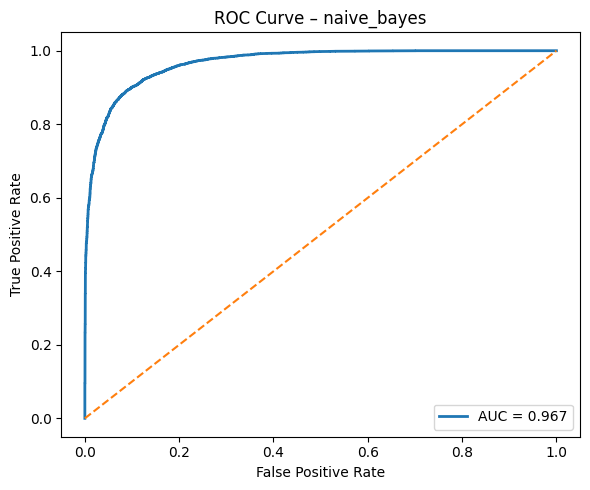

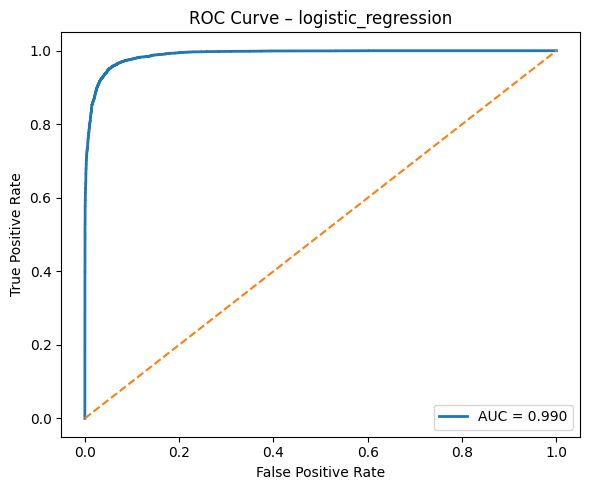

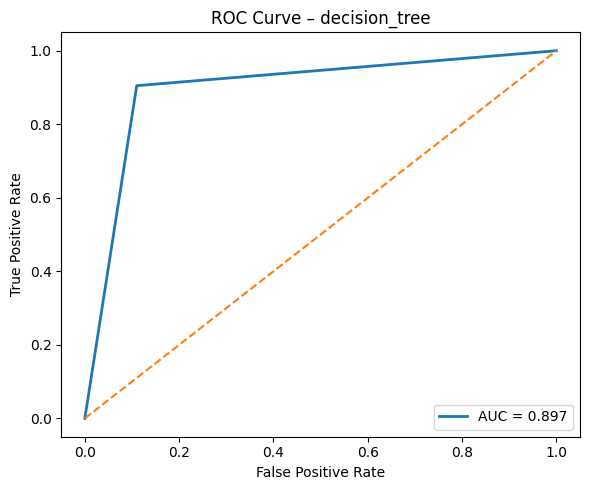

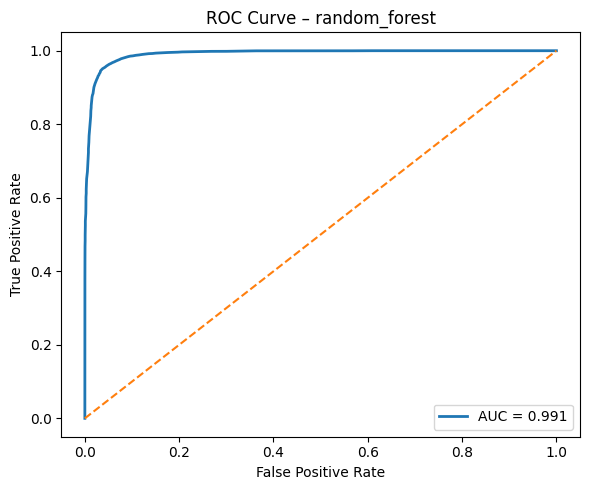

In [10]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curves(y_true, probability_dict):
    """
    Draws a separate ROC curve for each model.

    Parameters:
        y_true (array-like): Actual labels
        probability_dict (dict): {model_name: probability_scores}
    """

    for model_name, probs in probability_dict.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5)

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve – {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


# Usage Example
plot_roc_curves(y_test, probabilities)

In [15]:
# Tuned Random Forest modelini saxlamaq
joblib.dump(best_rf, "tuned_random_forest.pkl")
print("Tuned Random Forest model saved as 'tuned_random_forest.pkl'.")

# Vectorizer-i saxlamaq
joblib.dump(vectorizer_obj, "vectorizer.pkl")
print("Vectorizer saved as 'vectorizer.pkl'.")


Tuned Random Forest model saved as 'tuned_random_forest.pkl'.
Vectorizer saved as 'vectorizer.pkl'.


In [16]:
joblib.dump((best_rf, vectorizer_obj), "full_pipeline.pkl")

['full_pipeline.pkl']